# Cleaning the First data: Toronto Data Set

### We must scrape The Toronto data set from the web and convert it into data frame

#### Import libraries

In [1]:
!conda install -c anaconda beautifulsoup4 --yes
from bs4 import BeautifulSoup
import urllib.request
import csv
import pandas as pd

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2020.4.5~ --> anaconda::ca-certificates-2020.1.1-0
  certifi            conda-forge::certifi-2020.4.5.1-py36h~ --> anaconda::certifi-2020.4.5.1-py36_0
  openssl            conda-forge::openssl-1.1.1g-h516909a_0 --> anaconda::openssl-1.1.1g-h7b6447c_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [2]:
# specify the url
urlpage = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
# query the website and return the html to the variable 'page'
page = urllib.request.urlopen(urlpage)
# parse the html using beautiful soup and store in variable 
bsObj = BeautifulSoup(page, 'html.parser')
# find results within table
tab = bsObj.findAll("tbody")
data_list=[]
for ligne in tab[0].findAll("tr"):
    l=[]
    for cellule in ligne.findAll("td"):
        l.append(((str(cellule).replace("<td>","")).replace("</td>","")).replace("\n",""))
    data_list.append(l)
#The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
data=pd.DataFrame(data=data_list,columns=['Postalcode','Borough','Neighborhood'])
data.drop([0], inplace=True)

In [3]:
 #Ignore cells with a borough that is Not assigned.
data.drop(data[data.Borough =='Not assigned'].index, inplace=True)

In [4]:
#More than one neighborhood can exist in one postal code area.
data['Neighborhood'] = data.Neighborhood.str.replace('/',',')

In [5]:
#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
for row in data.iterrows():
    if row[1]['Neighborhood']=="":
        row[1]['Neighborhood']=row[1]['Borough']

In [6]:
data.head()

,Postalcode,Borough,Neighborhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### We use another dataset to complete the longitude and the Latitude of each Borough. 

In [7]:
geo_data=pd.read_csv('Geospatial_Coordinates.csv')
geo_data.rename(columns={"Postal Code": 'Postalcode'}, inplace=True)
geo_data.head()

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### After that we merge the two datasets

In [8]:
data2= data.assign(Latitude="", Longitude="") 
import numpy as np
for row in data2.iterrows():
    p=row[1]['Postalcode']
    x=geo_data[geo_data['Postalcode']==p][['Latitude','Longitude']].values[0]
    if x == []:
        print(p)
    else:
        row[1]['Latitude']=x[0]
        row[1]['Longitude']=x[1]
data2.head()  

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


,Postalcode,Borough,Neighborhood,Latitude,Longitude
3,M3A,North York,Parkwoods,43.7533,-79.3297
4,M4A,North York,Victoria Village,43.7259,-79.3156
5,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6543,-79.3606
6,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7185,-79.4648
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6623,-79.3895


### We will work with only boroughs that contain the word Toronto

In [9]:

def verif(row):
    return('Toronto' in row['Borough'])
data2=data2[data2.apply(verif, axis=1)]
print(len(data2['Postalcode'].unique()))
data2.head()

39


,Postalcode,Borough,Neighborhood,Latitude,Longitude
5,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6543,-79.3606
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6623,-79.3895
14,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3789
23,M5C,Downtown Toronto,St. James Town,43.6515,-79.3754
31,M4E,East Toronto,The Beaches,43.6764,-79.293


###  Finally, we use Foursquare location data to complete our data with the different venues categories of each neighborhood.

#### Import libraries

In [10]:
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be UPDATED:

  ca-certificates      anaconda::ca-certificates-2020.1.1-0 --> conda-forge::ca-certificates-2020.4.5.1-hecc5488_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi               anaconda::certifi-2020.4.5.1-py36_0 --> conda-forge::certifi-2020.4.5.1-py36h9f0ad1d_0
  openssl               anaconda::openssl-1.1.1g-h7b6447c_0 --> conda-forge::openssl-1.1.1g-h516909a_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Libraries imported.


### Request the foursquare API

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    CLIENT_ID = '53EEVY3F5MW5S2I2FV4YGU4QTBA3B41DBJDAA1PDDNWRBEPP' # your Foursquare ID
    CLIENT_SECRET = 'ICGTZOZHWLF0ATDISYNA0HM4SO0EUUAGE5HUZZ0FEKPA1GT2' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    LIMIT=100
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Toronto_venues = getNearbyVenues(names=data2['Neighborhood'],
                                   latitudes=data2['Latitude'],
                                   longitudes=data2['Longitude']
                                  )

Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


# Cleaning the Second data: New York DataSet

### Download Dataset

In [12]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [13]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

### Tranform the data into a pandas dataframe

In [14]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


### In the second step, we use Foursquare location data to complete our data with the different venues categories of each neighborhood. 

#### Request the foursquare Api and merge the result with the previous datset

In [15]:
CLIENT_ID = '53EEVY3F5MW5S2I2FV4YGU4QTBA3B41DBJDAA1PDDNWRBEPP' # your Foursquare ID
CLIENT_SECRET = 'ICGTZOZHWLF0ATDISYNA0HM4SO0EUUAGE5HUZZ0FEKPA1GT2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )


manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


# Exploratory Data Analysis

### Comparing the most popular Venues categories by neighborhoods

Make changes to the Toronto dataset

In [16]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()


In [17]:
#Let's print each neighborhood along with the top 5 most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


#let's create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Seafood Restaurant,Bakery,Beer Bar,Cheese Shop,Café,Gourmet Shop,Pub
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Bar,Intersection,Nightclub,Grocery Store,Gym,Convenience Store,Furniture / Home Store
2,Business reply mail Processing Centre,Yoga Studio,Skate Park,Fast Food Restaurant,Light Rail Station,Auto Workshop,Spa,Farmers Market,Recording Studio,Pizza Place,Burrito Place
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Coffee Shop,Harbor / Marina,Sculpture Garden,Boat or Ferry,Rental Car Location,Plane,Boutique
4,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Burger Joint,Bar,Japanese Restaurant,Salad Place,Thai Restaurant,Bubble Tea Shop


Make changes to the New York dataset

In [18]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()


In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_NY = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_NY['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted_NY.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_NY.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Memorial Site,Gym,Coffee Shop,Food Court,Beer Garden,Shopping Mall,Gourmet Shop,Boat or Ferry
1,Carnegie Hill,Coffee Shop,Grocery Store,Pizza Place,Japanese Restaurant,Gym / Fitness Center,Gym,Yoga Studio,Café,Bookstore,Bar
2,Central Harlem,African Restaurant,Cosmetics Shop,Chinese Restaurant,French Restaurant,American Restaurant,Bar,Seafood Restaurant,Public Art,Bookstore,Library
3,Chelsea,Art Gallery,Coffee Shop,Italian Restaurant,Ice Cream Shop,Boutique,Cycle Studio,Park,Café,Theater,Market
4,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Coffee Shop,American Restaurant,Spa,Optical Shop,Salon / Barbershop,Noodle House,Hotel


In [20]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style


In [21]:
def chart_pie_top(data_onehot,nbr):
    df=(data_onehot.transpose())
    df['Total'] = df.sum(axis=1)
    df2=pd.DataFrame(df['Total'])
    index=-1
    for i,row in df2.iterrows():
        if "Regent Park" in str(row['Total']):
            index=i
        if "HillMarble" in str(row['Total']):
            index=i
    if index!=-1:
        df2.drop(index , inplace=True)
    df2.sort_values(by='Total',ascending=False , inplace=True)
    df2=df2[:nbr]
    return df2
  

### Comparison of between the 10 Top Venues Categories in New York and Toronto

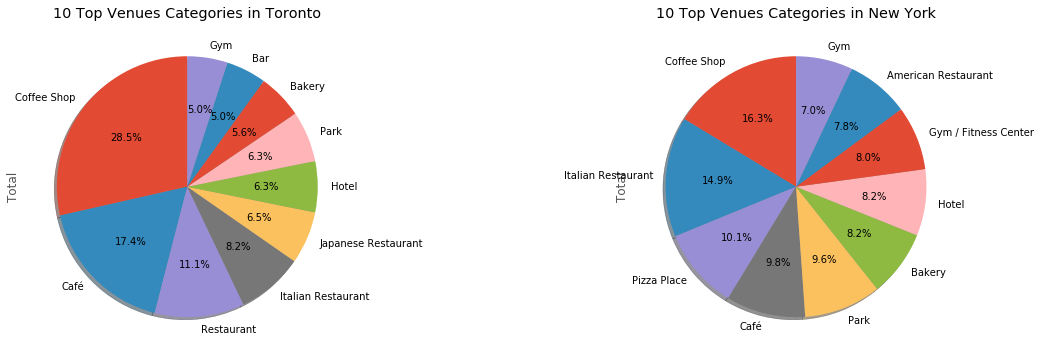

In [22]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: pie plot
(chart_pie_top(Toronto_onehot,10))['Total'].plot(kind='pie',
                            figsize=(20, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=True,       # add shadow      
                             ax=ax0)
ax0.set_title('10 Top Venues Categories in Toronto')

# Subplot 2: pie plot
(chart_pie_top(manhattan_onehot,10))['Total'].plot(kind='pie',
                            figsize=(20, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=True,       # add shadow      
                             ax=ax1)
ax1.set_title ('10 Top Venues Categories in New York')

plt.show()

The percentage of coffee shops represents the largest percentage in Toronto and New York. Note that New York has more parks than Toronto.

### Comparison of between the 10 least Venues Categories in New York and Toronto

In [23]:
def chart_pie_least(data_onehot,nbr):
    df=(data_onehot.transpose())
    df['Total'] = df.sum(axis=1)
    df2=pd.DataFrame(df['Total'])
    index=-1
    for i,row in df2.iterrows():
        if "Regent Park" in str(row['Total']):
            index=i
        if "HillMarble" in str(row['Total']):
            index=i
    if index!=-1:
        df2.drop(index , inplace=True)
    df2.sort_values(by='Total',ascending=True , inplace=True)
    df2=df2[:nbr]
    return df2

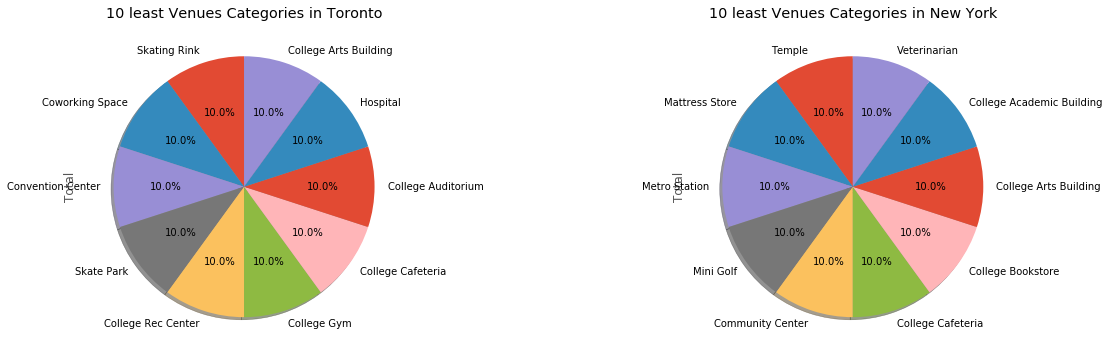

In [24]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: pie plot
(chart_pie_least(Toronto_onehot,10))['Total'].plot(kind='pie',
                            figsize=(20, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=True,       # add shadow  
                             ax=ax0)
ax0.set_title('10 least Venues Categories in Toronto')

# Subplot 2: pie plot
(chart_pie_least(manhattan_onehot,10))['Total'].plot(kind='pie',
                            figsize=(20, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=True,       # add shadow 
                             ax=ax1)
ax1.set_title ('10 least Venues Categories in New York')

plt.show()

We note that the number of hospitals is among the lowest in Toronto.
Note also,the metro stations services, the mini golf services are among the least existing services in New York.

### Comparison between the Venues Categories Distribution of New York and Toronto

In [25]:
def chart_pie(data_onehot,nbr):
    df=(data_onehot.transpose())
    df['Total'] = df.sum(axis=1)
    df2=pd.DataFrame(df['Total'])
    index=-1
    for i,row in df2.iterrows():
        if "Regent Park" in str(row['Total']):
            index=i
        if "HillMarble" in str(row['Total']):
            index=i
    if index!=-1:
        df2.drop(index , inplace=True)
    df2.sort_values(by='Total',ascending=False , inplace=True)
    df2=df2[:nbr]
    return df2
  

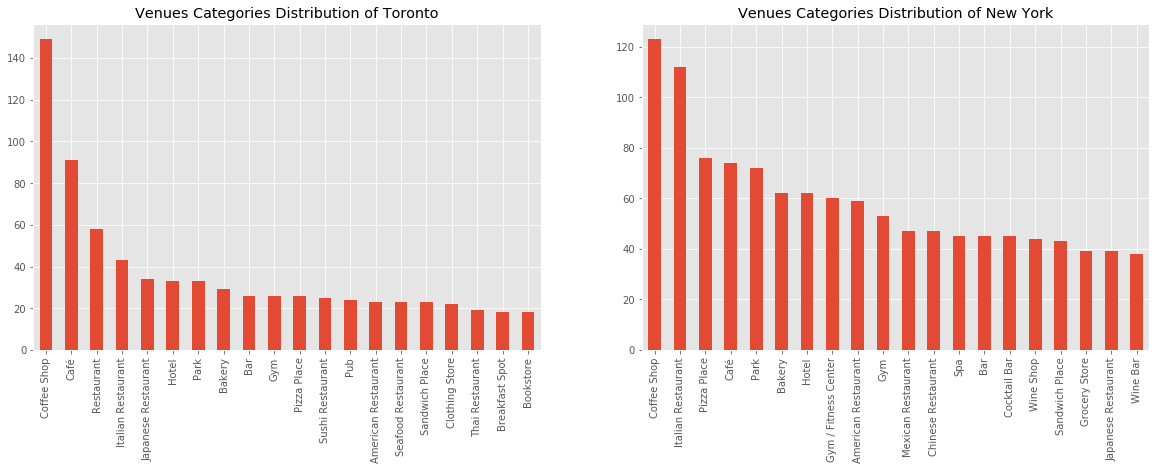

In [26]:

fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: bar plot
(chart_pie(Toronto_onehot,20))['Total'].plot(kind='bar',
                            figsize=(20, 6),  
                             ax=ax0)
ax0.set_title('Venues Categories Distribution of Toronto')

# Subplot 2: bar plot
(chart_pie(manhattan_onehot,20))['Total'].plot(kind='bar',
                            figsize=(20, 6),    
                             ax=ax1)
ax1.set_title ('Venues Categories Distribution of New York')

plt.show()

We note that the number of coffee shops is almost similar whether in Toronto or New York. Note also that the number of Italian restaurants and Pizza Place in New York is significantly larger than in Toronto. Overall, New York has more services than Toronto.

# Clustering 

In [27]:
#Cluster Neighborhoods

# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = data2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
#Finally, let's visualize the resulting clusters
# create map
latitude=43.6764
longitude=-79.293
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [29]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Downtown Toronto,0,Coffee Shop,Bakery,Park,Pub,Café,Theater,Breakfast Spot,Restaurant,Electronics Store,Event Space
7,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Beer Bar,Restaurant,Bank,Bar,Café,Diner,Discount Store,Yoga Studio
14,Downtown Toronto,0,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Cosmetics Shop,Restaurant,Japanese Restaurant,Italian Restaurant,Middle Eastern Restaurant,Tea Room
23,Downtown Toronto,0,Café,Coffee Shop,Gastropub,Cocktail Bar,American Restaurant,Clothing Store,Italian Restaurant,Seafood Restaurant,Beer Bar,Moroccan Restaurant
31,East Toronto,0,Trail,Health Food Store,Pub,Women's Store,Cupcake Shop,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
32,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Restaurant,Seafood Restaurant,Bakery,Beer Bar,Cheese Shop,Café,Gourmet Shop,Pub
41,Downtown Toronto,0,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Burger Joint,Bar,Japanese Restaurant,Salad Place,Thai Restaurant,Bubble Tea Shop
42,Downtown Toronto,0,Grocery Store,Café,Park,Candy Store,Italian Restaurant,Diner,Restaurant,Baby Store,Athletics & Sports,Nightclub
50,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Deli / Bodega,Thai Restaurant,Clothing Store,Hotel,Gym,Seafood Restaurant,Sushi Restaurant
51,West Toronto,0,Bakery,Pharmacy,Supermarket,Park,Pool,Café,Middle Eastern Restaurant,Athletics & Sports,Bar,Liquor Store


In [28]:
latitude = 40.7127281
longitude = -74.0060152
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted_NY.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted_NY.set_index('Neighborhood'), on='Neighborhood')

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


In [30]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Manhattanville,Seafood Restaurant,Coffee Shop,Italian Restaurant,Mexican Restaurant,Fried Chicken Joint,Park,Deli / Bodega,Boutique,Supermarket,Spanish Restaurant
8,Upper East Side,Italian Restaurant,Juice Bar,Bakery,Exhibit,Gym / Fitness Center,Hotel,Yoga Studio,Wine Shop,Pizza Place,Cosmetics Shop
9,Yorkville,Coffee Shop,Italian Restaurant,Gym,Bar,Deli / Bodega,Japanese Restaurant,Mexican Restaurant,Sushi Restaurant,Diner,Wine Shop
10,Lenox Hill,Italian Restaurant,Coffee Shop,Pizza Place,Café,Sushi Restaurant,Cocktail Bar,Burger Joint,Gym / Fitness Center,Gym,Mexican Restaurant
12,Upper West Side,Italian Restaurant,Coffee Shop,Wine Bar,Bakery,Bookstore,Bar,Bagel Shop,Mediterranean Restaurant,Thai Restaurant,Seafood Restaurant
13,Lincoln Square,Plaza,Café,Concert Hall,Performing Arts Venue,Gym / Fitness Center,Theater,Italian Restaurant,American Restaurant,Wine Shop,Indie Movie Theater
18,Greenwich Village,Italian Restaurant,Gym,Sushi Restaurant,Wine Bar,Bakery,Coffee Shop,Pizza Place,Gourmet Shop,Dog Run,Dessert Shop
21,Tribeca,Italian Restaurant,Park,Wine Bar,Café,Spa,Art Gallery,Greek Restaurant,Skate Park,Scenic Lookout,Poke Place
23,Soho,Italian Restaurant,Mediterranean Restaurant,Gym,Coffee Shop,Spa,Bakery,Café,Clothing Store,French Restaurant,Art Gallery
24,West Village,Wine Bar,Italian Restaurant,Coffee Shop,American Restaurant,Jazz Club,New American Restaurant,Park,Bakery,Seafood Restaurant,Theater
